# Feature Transformations

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from scipy import stats

## Learning Objectives

- Use correlations and other algorithms to inform feature selection
- Create new features for use in modeling
    - Use binning to turn numerical into categorical features
    - Use `PolynomialFeatures` to build compound features

## Model Selection

Let's imagine that I'm going to try to predict wine quality based on the other features.

In [2]:
wine = pd.read_csv('data/wine.csv')

In [3]:
wine.head(10)

fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0            7.4              0.70         0.00             1.9      0.076   
1            7.8              0.88         0.00             2.6      0.098   
2            7.8              0.76         0.04             2.3      0.092   
3           11.2              0.28         0.56             1.9      0.075   
4            7.4              0.70         0.00             1.9      0.076   
5            7.4              0.66         0.00             1.8      0.075   
6            7.9              0.60         0.06             1.6      0.069   
7            7.3              0.65         0.00             1.2      0.065   
8            7.8              0.58         0.02             2.0      0.073   
9            7.5              0.50         0.36             6.1      0.071   

   free sulfur dioxide  total sulfur dioxide  density    pH  sulphates  \
0                 11.0                  34.0   0.9978  3.51       0.56   
1                 25.0                  67.0   0.9968  3.20       0.68   
2                 15.0                  54.0   0.9970  3.26       0.65   
3                 17.0                  60.0   0.9980  3.16       0.58   
4                 11.0                  34.0   0.9978  3.51       0.56   
5                 13.0                  40.0   0.9978  3.51       0.56   
6                 15.0                  59.0   0.9964  3.30       0.46   
7                 15.0                  21.0   0.9946  3.39       0.47   
8                  9.0                  18.0   0.9968  3.36       0.57   
9                 17.0                 102.0   0.9978  3.35       0.80   

   alcohol  quality  red_wine  
0      9.4        5         1  
1      9.8        5         1  
2      9.8        5         1  
3      9.8        6         1  
4      9.4        5         1  
5      9.4        5         1  
6      9.4        5         1  
7     10.0        7         1  
8      9.5        7         1  
9     10.5        5         1

In [4]:
wine['quality'].value_counts()

6    2836
5    2138
7    1079
4     216
8     193
3      30
9       5
Name: quality, dtype: int64

## Decisions, Decisions, Decisions...

Now: Which columns (predictors) should I choose? 

There are 12 predictors I could choose from. For each of these predictors, I could either use it or not use it in my model, which means that there are $2^{12} = 4096$ _different_ models I could construct! Well, okay, one of these is the "empty model" with no predictors in it. But there are still 4095 models from which I can choose.

How can I decide which predictors to use in my model?

We'll explore a few methods in the sections below.

## Correlation

Our first attempt might be just see which features are _correlated_ with the target to make a prediction.

We can use the correlation metric in making a decision.

In [5]:
# Use the .corr() DataFrame method to find out about the
# correlation values between all pairs of variables!

wine.corr()

fixed acidity  volatile acidity  citric acid  \
fixed acidity              1.000000          0.219008     0.324436   
volatile acidity           0.219008          1.000000    -0.377981   
citric acid                0.324436         -0.377981     1.000000   
residual sugar            -0.111981         -0.196011     0.142451   
chlorides                  0.298195          0.377124     0.038998   
free sulfur dioxide       -0.282735         -0.352557     0.133126   
total sulfur dioxide      -0.329054         -0.414476     0.195242   
density                    0.458910          0.271296     0.096154   
pH                        -0.252700          0.261454    -0.329808   
sulphates                  0.299568          0.225984     0.056197   
alcohol                   -0.095452         -0.037640    -0.010493   
quality                   -0.076743         -0.265699     0.085532   
red_wine                   0.486740          0.653036    -0.187397   

                      residual sugar  chlorides  free sulfur dioxide  \
fixed acidity              -0.111981   0.298195            -0.282735   
volatile acidity           -0.196011   0.377124            -0.352557   
citric acid                 0.142451   0.038998             0.133126   
residual sugar              1.000000  -0.128940             0.402871   
chlorides                  -0.128940   1.000000            -0.195045   
free sulfur dioxide         0.402871  -0.195045             1.000000   
total sulfur dioxide        0.495482  -0.279630             0.720934   
density                     0.552517   0.362615             0.025717   
pH                         -0.267320   0.044708            -0.145854   
sulphates                  -0.185927   0.395593            -0.188457   
alcohol                    -0.359415  -0.256916            -0.179838   
quality                    -0.036980  -0.200666             0.055463   
red_wine                   -0.348821   0.512678            -0.471644   

                      total sulfur dioxide   density        pH  sulphates  \
fixed acidity                    -0.329054  0.458910 -0.252700   0.299568   
volatile acidity                 -0.414476  0.271296  0.261454   0.225984   
citric acid                       0.195242  0.096154 -0.329808   0.056197   
residual sugar                    0.495482  0.552517 -0.267320  -0.185927   
chlorides                        -0.279630  0.362615  0.044708   0.395593   
free sulfur dioxide               0.720934  0.025717 -0.145854  -0.188457   
total sulfur dioxide              1.000000  0.032395 -0.238413  -0.275727   
density                           0.032395  1.000000  0.011686   0.259478   
pH                               -0.238413  0.011686  1.000000   0.192123   
sulphates                        -0.275727  0.259478  0.192123   1.000000   
alcohol                          -0.265740 -0.686745  0.121248  -0.003029   
quality                          -0.041385 -0.305858  0.019506   0.038485   
red_wine                         -0.700357  0.390645  0.329129   0.487218   

                       alcohol   quality  red_wine  
fixed acidity        -0.095452 -0.076743  0.486740  
volatile acidity     -0.037640 -0.265699  0.653036  
citric acid          -0.010493  0.085532 -0.187397  
residual sugar       -0.359415 -0.036980 -0.348821  
chlorides            -0.256916 -0.200666  0.512678  
free sulfur dioxide  -0.179838  0.055463 -0.471644  
total sulfur dioxide -0.265740 -0.041385 -0.700357  
density              -0.686745 -0.305858  0.390645  
pH                    0.121248  0.019506  0.329129  
sulphates            -0.003029  0.038485  0.487218  
alcohol               1.000000  0.444319 -0.032970  
quality               0.444319  1.000000 -0.119323  
red_wine             -0.032970 -0.119323  1.000000

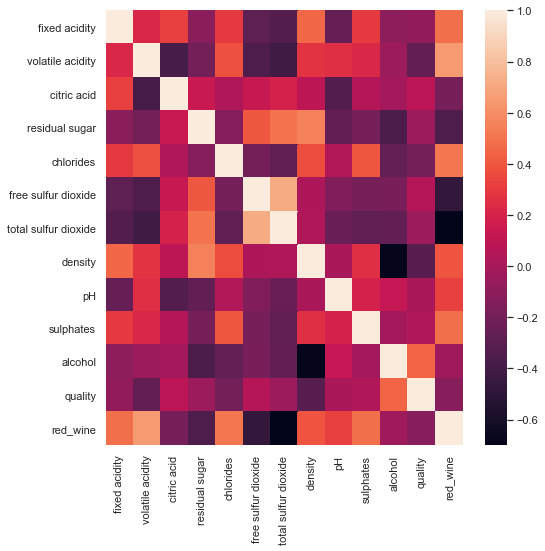

In [6]:
sns.set(rc={'figure.figsize':(8, 8)})

# Use the .heatmap function to depict the relationships visually!
sns.heatmap(wine.corr());

In [7]:
# Let's look at the correlations with 'quality'
# (our dependent variable) in particular.

wine_corrs = wine.corr()['quality'].map(abs).sort_values(ascending=False)
wine_corrs

quality                 1.000000
alcohol                 0.444319
density                 0.305858
volatile acidity        0.265699
chlorides               0.200666
red_wine                0.119323
citric acid             0.085532
fixed acidity           0.076743
free sulfur dioxide     0.055463
total sulfur dioxide    0.041385
sulphates               0.038485
residual sugar          0.036980
pH                      0.019506
Name: quality, dtype: float64

It looks like we can see the features have different correlations with the target. The larger the correlation, the more we'd expect these features to be better predictors.

Let's try using only a subset of the strongest correlated features to make our model.

In [9]:
# Let's choose 'alcohol' and 'density'.

wine_preds = wine[['alcohol', 'density']]
wine_target = wine['quality']
preds_with_const = sm.add_constant(wine_preds)

In [10]:
model = sm.OLS(endog=wine_target, exog=preds_with_const).fit()

In [12]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                quality   R-squared:                       0.197
Model:                            OLS   Adj. R-squared:                  0.197
Method:                 Least Squares   F-statistic:                     798.7
Date:                Wed, 22 Mar 2023   Prob (F-statistic):          7.48e-311
Time:                        15:20:40   Log-Likelihood:                -7623.4
No. Observations:                6497   AIC:                         1.525e+04
Df Residuals:                    6494   BIC:                         1.527e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.8095      4.512      0.623      0.533      -6.035      11.654
alcohol        0.3246      0.011     28.991      0.000       0.303       0.347
density       -0.3991      4.454     -0.090      0.929      -9.130       8.332
==============================================================================
Omnibus:                      123.912   Durbin-Watson:                   1.636
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              258.761
Skew:                           0.031   Prob(JB):                     6.47e-57
Kurtosis:                       3.976   Cond. No.                     6.96e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.96e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [11]:
model.rsquared

0.19741993980311334

## Feature Engineering

> Domain knowledge can be helpful here! 🧠

In practice this aspect of data preparation can constitute a huge part of the data scientist's work. As we move into data modeling, much of the goal will be a matter of finding––**or creating**––features that are predictive of the targets we are trying to model.

There are infinitely many ways of transforming and combining a starting set of features. Good data scientists will have a nose for which engineering operations will be likely to yield fruit and for which operations won't. And part of the game here may be getting someone else on your team who understands what the data represent better than you!

Let's try this ourselves! Since I don't know much about wine, I'm really just guessing.

In [13]:
wine.head(10)

fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0            7.4              0.70         0.00             1.9      0.076   
1            7.8              0.88         0.00             2.6      0.098   
2            7.8              0.76         0.04             2.3      0.092   
3           11.2              0.28         0.56             1.9      0.075   
4            7.4              0.70         0.00             1.9      0.076   
5            7.4              0.66         0.00             1.8      0.075   
6            7.9              0.60         0.06             1.6      0.069   
7            7.3              0.65         0.00             1.2      0.065   
8            7.8              0.58         0.02             2.0      0.073   
9            7.5              0.50         0.36             6.1      0.071   

   free sulfur dioxide  total sulfur dioxide  density    pH  sulphates  \
0                 11.0                  34.0   0.9978  3.51       0.56   
1                 25.0                  67.0   0.9968  3.20       0.68   
2                 15.0                  54.0   0.9970  3.26       0.65   
3                 17.0                  60.0   0.9980  3.16       0.58   
4                 11.0                  34.0   0.9978  3.51       0.56   
5                 13.0                  40.0   0.9978  3.51       0.56   
6                 15.0                  59.0   0.9964  3.30       0.46   
7                 15.0                  21.0   0.9946  3.39       0.47   
8                  9.0                  18.0   0.9968  3.36       0.57   
9                 17.0                 102.0   0.9978  3.35       0.80   

   alcohol  quality  red_wine  
0      9.4        5         1  
1      9.8        5         1  
2      9.8        5         1  
3      9.8        6         1  
4      9.4        5         1  
5      9.4        5         1  
6      9.4        5         1  
7     10.0        7         1  
8      9.5        7         1  
9     10.5        5         1

## Distribution Transformations

### Log Scaling

Linear regression can work better if the predictor and target are normally distributed. 

**Log-scaling** can be a good tool to make *right-skewed* data more normal.

(For *left-skewed* data, which is rarer, we can try transforming our data by raising it to an exponent greater than 1.)

Suppose e.g. a kde plot of my predictor $X$ looks like this:

![original](images/skewplot.png)

In that case, the kde plot of a log-transformed version of $X$ could look like this:

![log](images/logplot.png)

Let's set up a problem like this.

In [14]:
diamonds = sns.load_dataset('diamonds')

In [16]:
diamonds.head()

carat      cut color clarity  depth  table  price     x     y     z
0   0.23    Ideal     E     SI2   61.5   55.0    326  3.95  3.98  2.43
1   0.21  Premium     E     SI1   59.8   61.0    326  3.89  3.84  2.31
2   0.23     Good     E     VS1   56.9   65.0    327  4.05  4.07  2.31
3   0.29  Premium     I     VS2   62.4   58.0    334  4.20  4.23  2.63
4   0.31     Good     J     SI2   63.3   58.0    335  4.34  4.35  2.75

In [15]:
X = diamonds.select_dtypes(include=float)
y = diamonds['price']

### Build model

In [23]:
model1 = sm.OLS(endog=y, exog=sm.add_constant(X)).fit()

In [24]:
model1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.859
Model:                            OLS   Adj. R-squared:                  0.859
Method:                 Least Squares   F-statistic:                 5.486e+04
Date:                Wed, 22 Mar 2023   Prob (F-statistic):               0.00
Time:                        15:36:27   Log-Likelihood:            -4.7090e+05
No. Observations:               53940   AIC:                         9.418e+05
Df Residuals:                   53933   BIC:                         9.419e+05
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       2.085e+04    447.562     46.584      0.000       2e+04    2.17e+04
carat       1.069e+04     63.201    169.085      0.000    1.06e+04    1.08e+04
depth       -203.1541      5.504    -36.910      0.000    -213.942    -192.366
table       -102.4457      3.084    -33.216      0.000    -108.491     -96.401
x          -1315.6678     43.070    -30.547      0.000   -1400.086   -1231.250
y             66.3216     25.523      2.599      0.009      16.296     116.347
z             41.6277     44.305      0.940      0.347     -45.210     128.465
==============================================================================
Omnibus:                    14093.399   Durbin-Watson:                   1.249
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           373568.966
Skew:                           0.674   Prob(JB):                         0.00
Kurtosis:                      15.822   Cond. No.                     5.91e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.91e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### Check distribution of target

<AxesSubplot:>

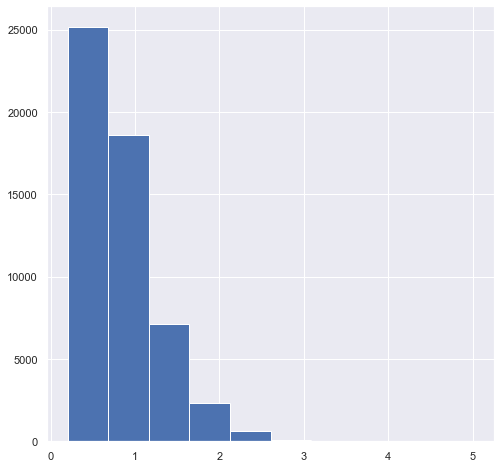

In [45]:
X['carat'].hist()

<AxesSubplot:>

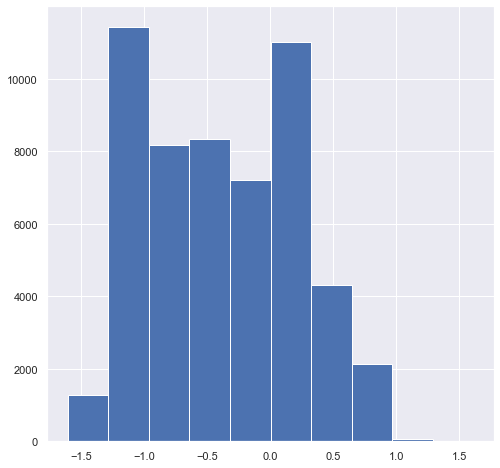

In [46]:
x_logged = np.log(X['carat'])
x_logged.hist()

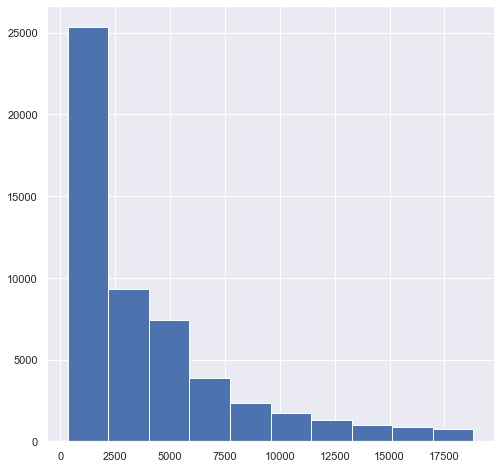

In [20]:
y.hist();

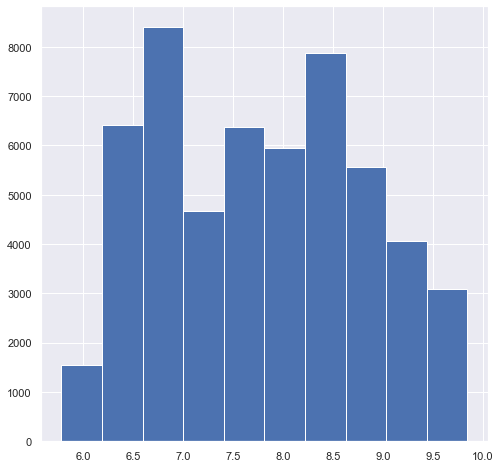

In [21]:
y_scld = np.log(y)
y_scld.hist();

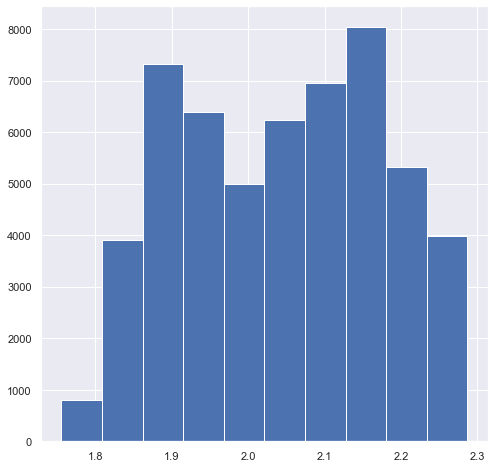

In [34]:
y_scld2 = np.log(y_scld)
y_scld2.hist();

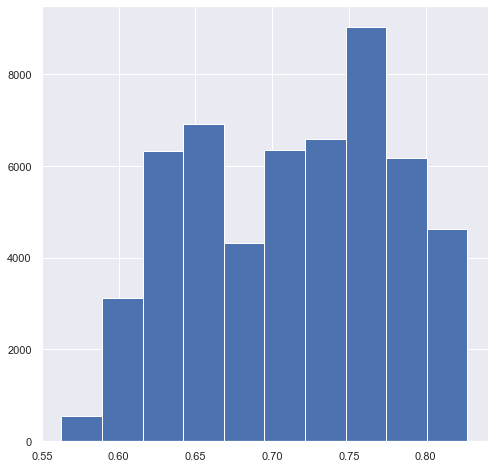

In [35]:
y_scld3 = np.log(y_scld2)
y_scld3.hist();

### Build model with log-scaled target

In [22]:
model_diam = sm.OLS(y_scld, sm.add_constant(X)).fit()
model_diam.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.924
Model:                            OLS   Adj. R-squared:                  0.924
Method:                 Least Squares   F-statistic:                 1.095e+05
Date:                Wed, 22 Mar 2023   Prob (F-statistic):               0.00
Time:                        15:35:59   Log-Likelihood:                -7776.1
No. Observations:               53940   AIC:                         1.557e+04
Df Residuals:                   53933   BIC:                         1.563e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.8952      0.084     10.712      0.000       0.731       1.059
carat         -0.7028      0.012    -59.551      0.000      -0.726      -0.680
depth          0.0220      0.001     21.403      0.000       0.020       0.024
table         -0.0098      0.001    -16.989      0.000      -0.011      -0.009
x              1.0757      0.008    133.763      0.000       1.060       1.091
y              0.0456      0.005      9.576      0.000       0.036       0.055
z              0.0648      0.008      7.836      0.000       0.049       0.081
==============================================================================
Omnibus:                    49564.202   Durbin-Watson:                   1.368
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         24894704.347
Skew:                           3.544   Prob(JB):                         0.00
Kurtosis:                     108.007   Cond. No.                     5.91e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.91e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [25]:
model1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.859
Model:                            OLS   Adj. R-squared:                  0.859
Method:                 Least Squares   F-statistic:                 5.486e+04
Date:                Wed, 22 Mar 2023   Prob (F-statistic):               0.00
Time:                        15:36:44   Log-Likelihood:            -4.7090e+05
No. Observations:               53940   AIC:                         9.418e+05
Df Residuals:                   53933   BIC:                         9.419e+05
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       2.085e+04    447.562     46.584      0.000       2e+04    2.17e+04
carat       1.069e+04     63.201    169.085      0.000    1.06e+04    1.08e+04
depth       -203.1541      5.504    -36.910      0.000    -213.942    -192.366
table       -102.4457      3.084    -33.216      0.000    -108.491     -96.401
x          -1315.6678     43.070    -30.547      0.000   -1400.086   -1231.250
y             66.3216     25.523      2.599      0.009      16.296     116.347
z             41.6277     44.305      0.940      0.347     -45.210     128.465
==============================================================================
Omnibus:                    14093.399   Durbin-Watson:                   1.249
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           373568.966
Skew:                           0.674   Prob(JB):                         0.00
Kurtosis:                      15.822   Cond. No.                     5.91e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.91e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### Interpreting Log-Transformed Coefficients

But with this transformed target, how do I now interpret my LR coefficients?

Before the transformation, I would have said that a one-unit increase in, say, depth results on average in a 0.0319 increase in price. But what I need to say now is that a one-unit increase in depth results on average in a 0.0319 increase *in the logarithm of price*, i.e. an increase in price by a factor of $e^{0.0319}$.

In [36]:
print(f"""
A one-unit increase in the depth variable corresponds
to an increase in price by a factor of {round(np.exp(0.0220), 3)},
or {100 * round(np.exp(0.0220) - 1, 3)}%.
""")


A one-unit increase in the depth variable corresponds
to an increase in price by a factor of 1.022,
or 2.1999999999999997%.



In [33]:
2500 * .022

55.0

In [30]:
2500 * 1.022

2555.0

In [29]:
np.exp(.0220)

1.0222437844704382

For more on this, including how to interpret coefficients after log-transforming *independent* variables, check out [this resource](https://data.library.virginia.edu/interpreting-log-transformations-in-a-linear-model/).

## Binning

To start we'll look at some `seaborn` Pair Plots. We'll do this in two halves so that we can see things a bit more clearly:

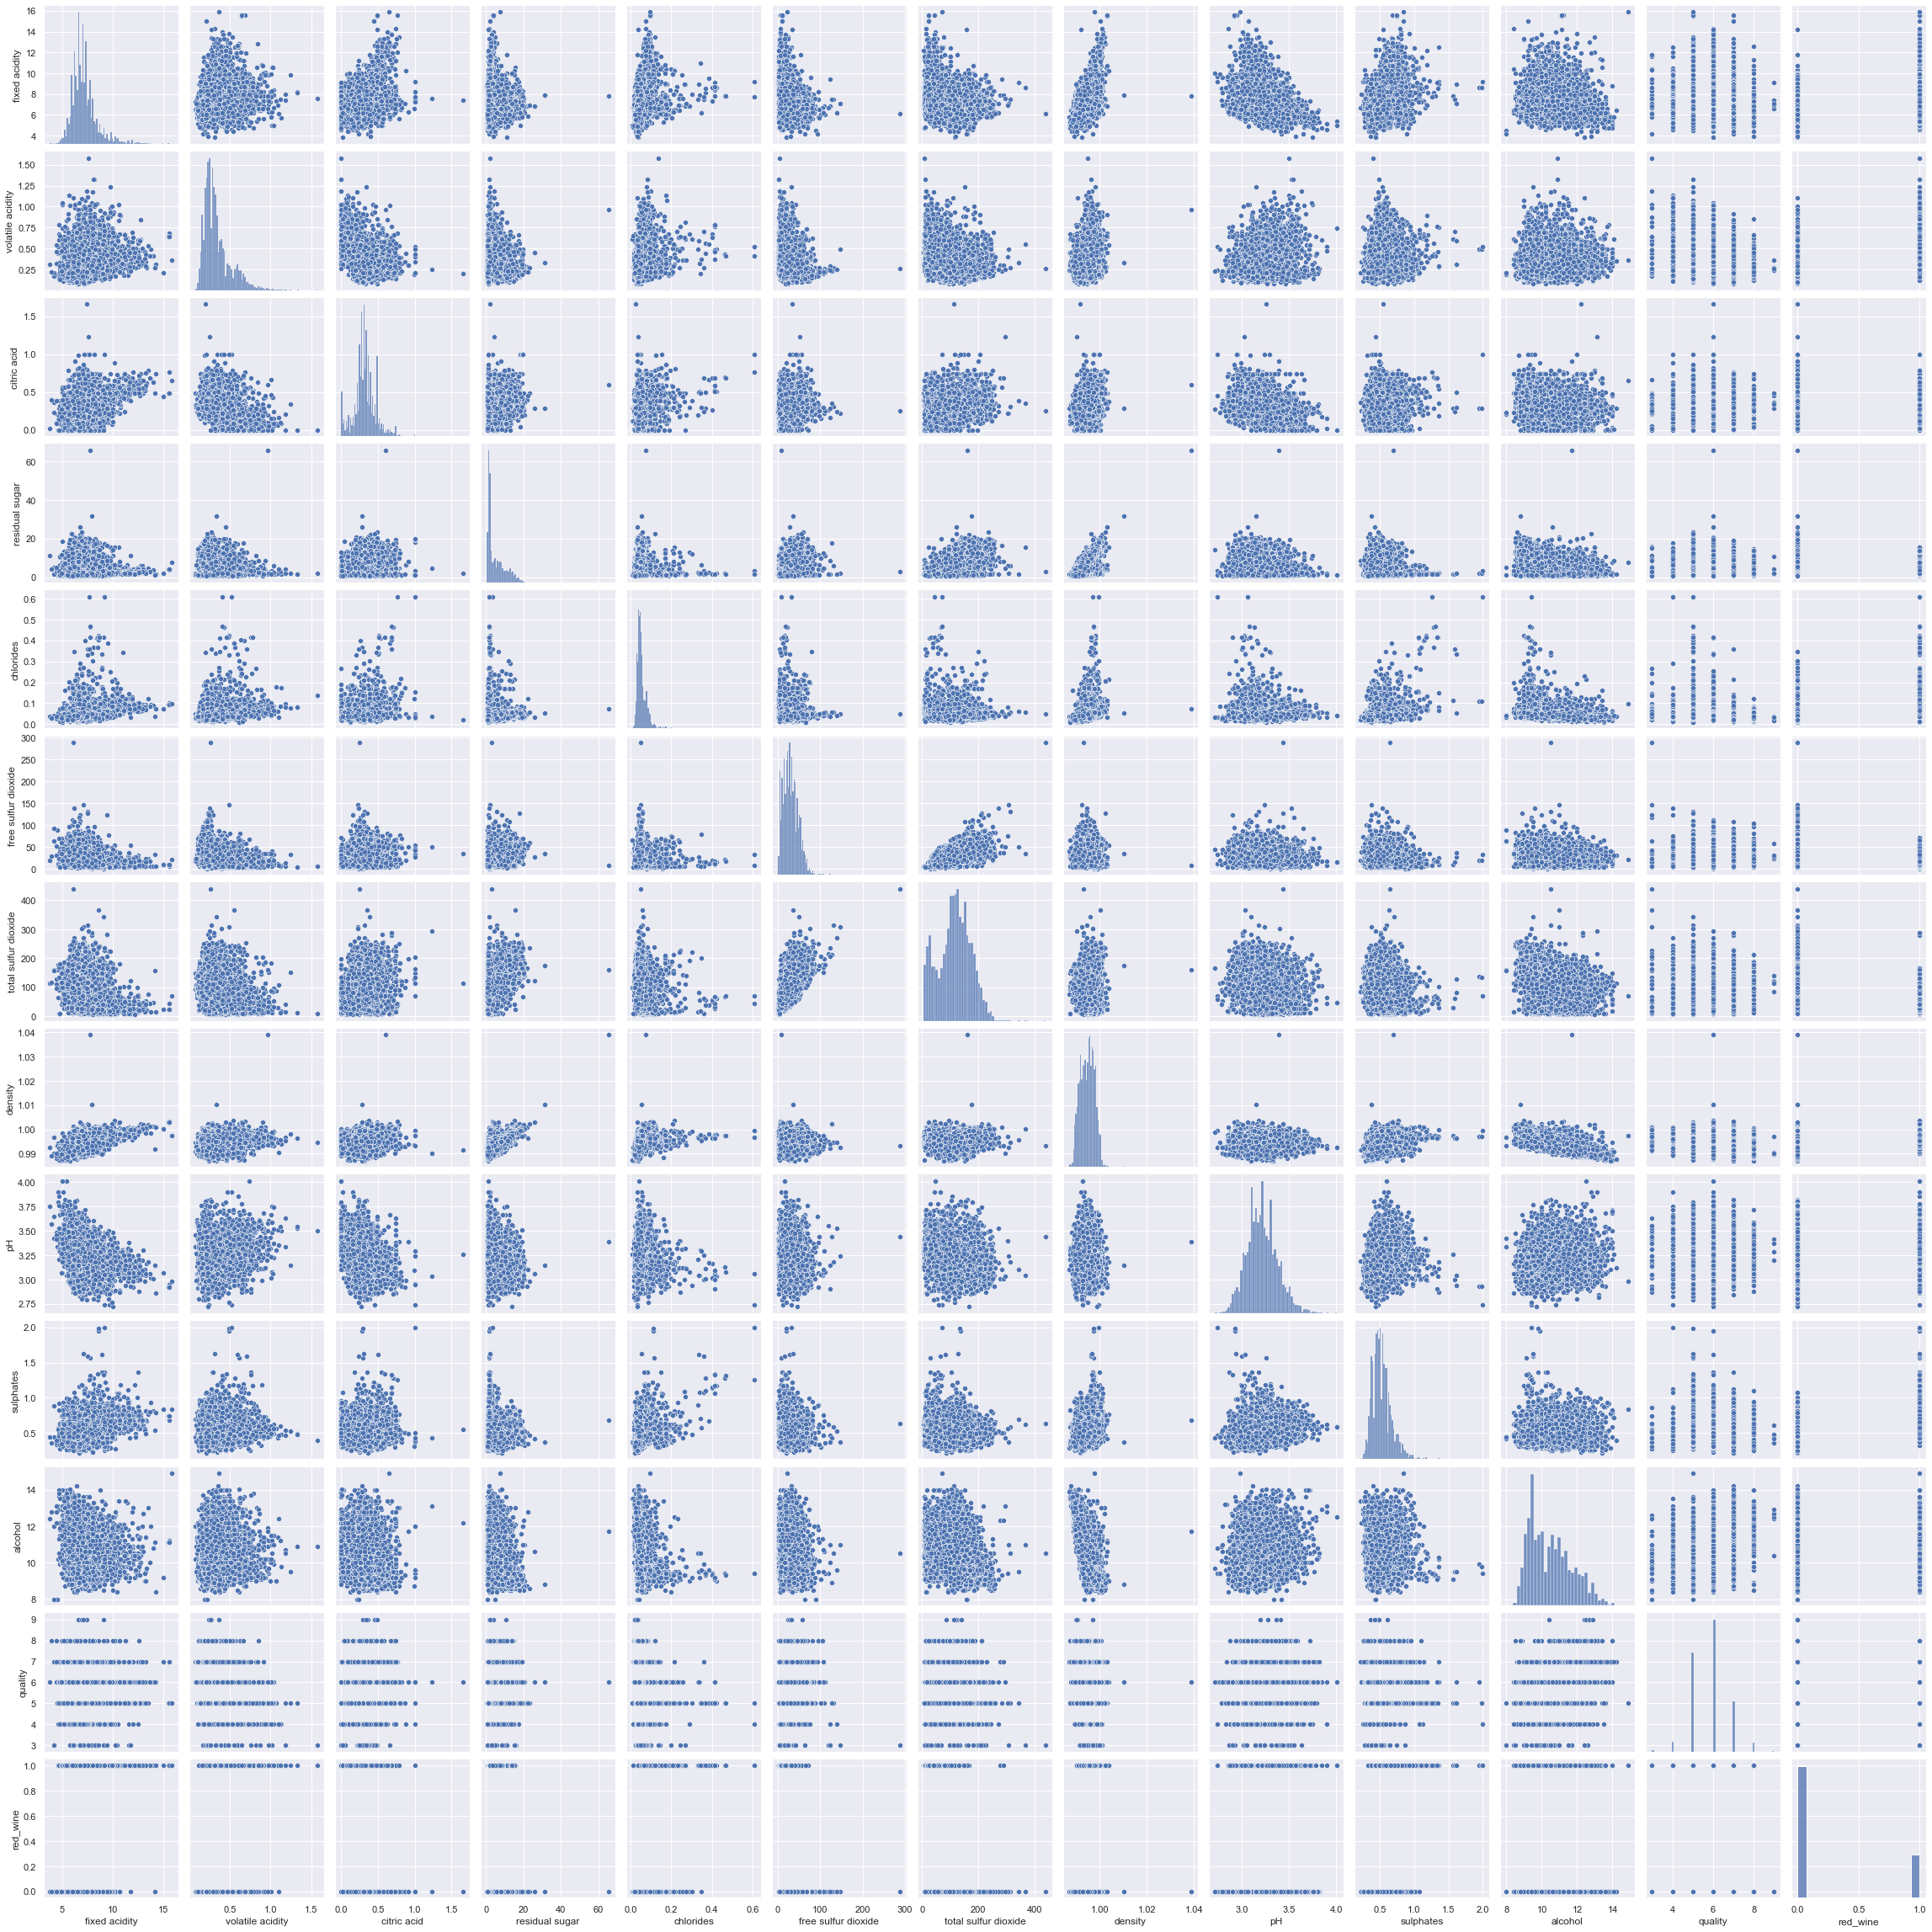

In [47]:
sns.pairplot(data=wine)

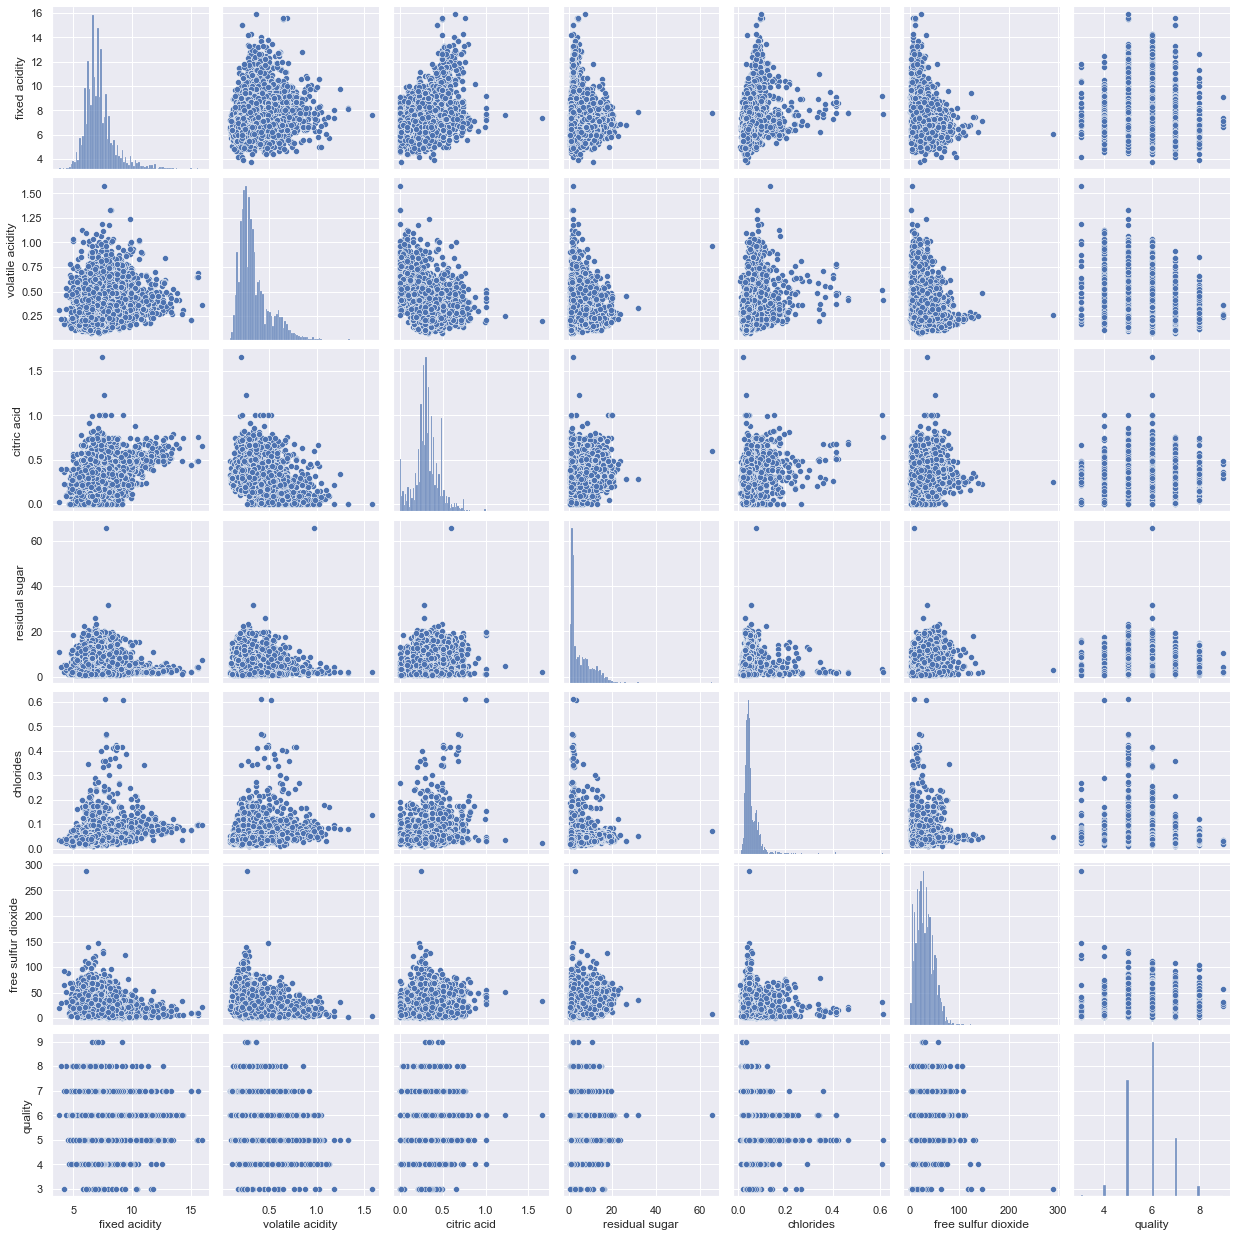

In [48]:
# This will show the first six predictors and 'quality'
columns = [True if j < 6 or j == 11 else False for j in range(13)]

sns.pairplot(data=wine.iloc[:, columns]);

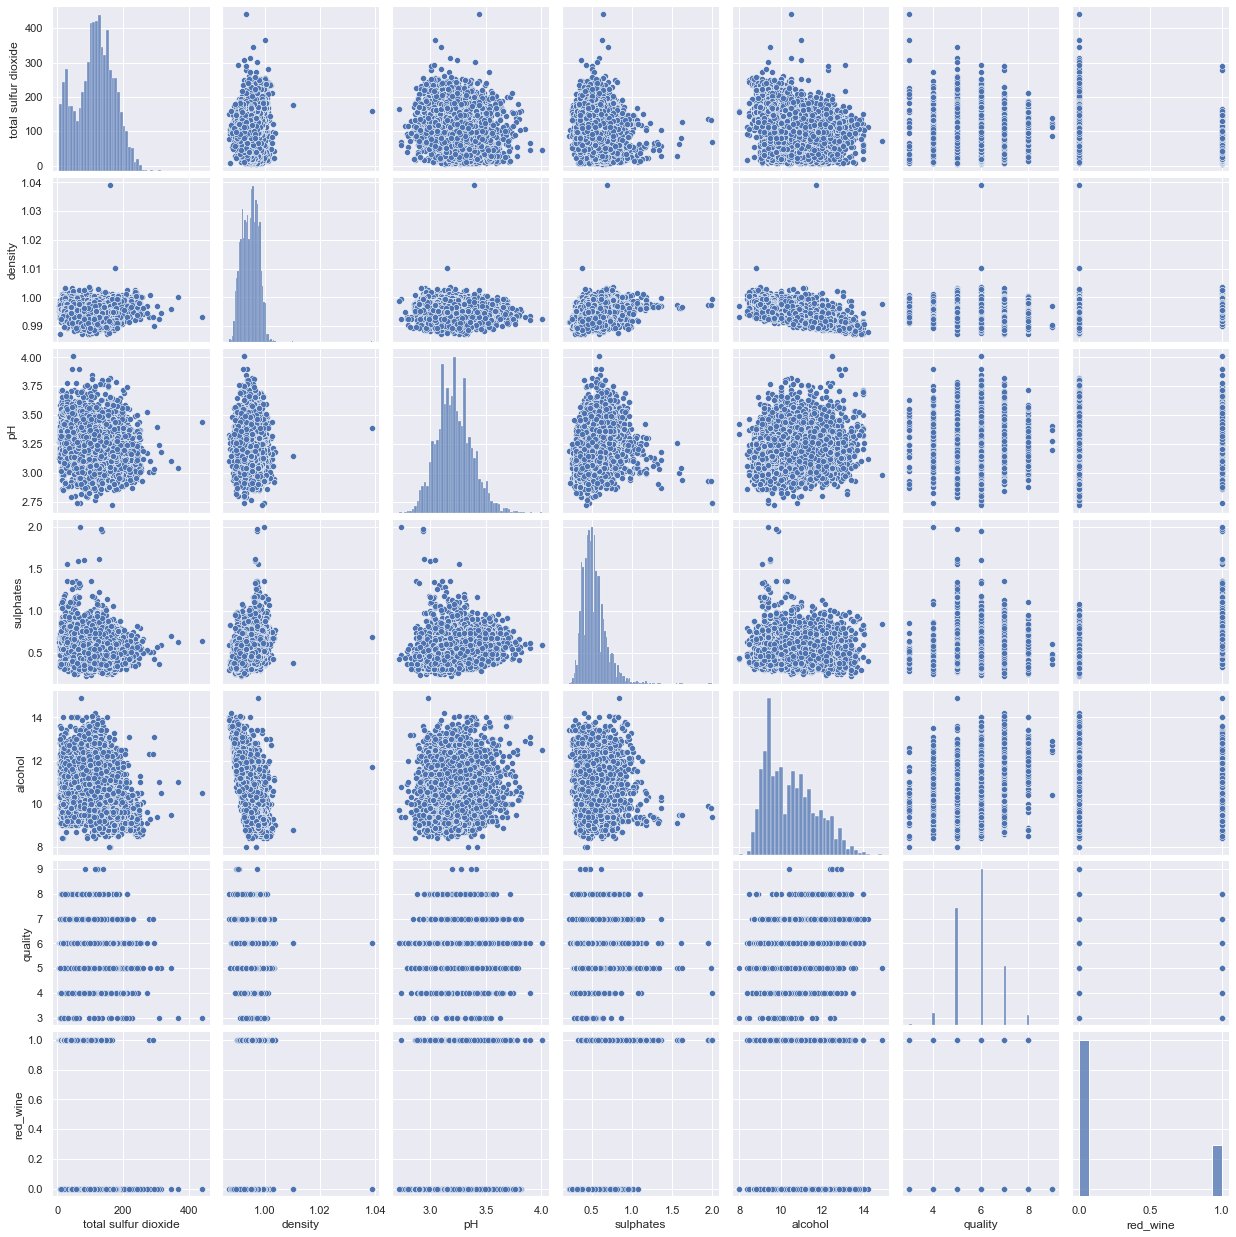

In [49]:
sns.pairplot(data=wine.iloc[:, 6:]);

### Volatile Acidity

Let's look at the distribution of the volatile acidity feature:

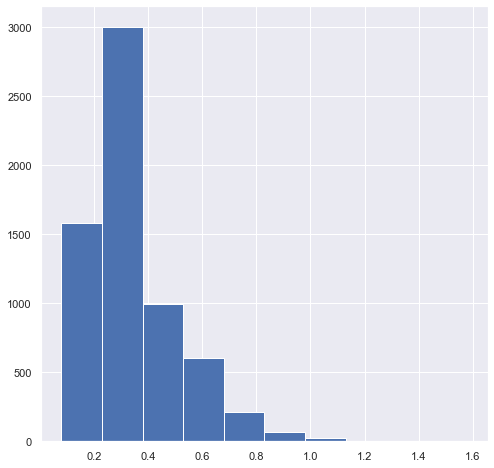

In [50]:
wine['volatile acidity'].hist();

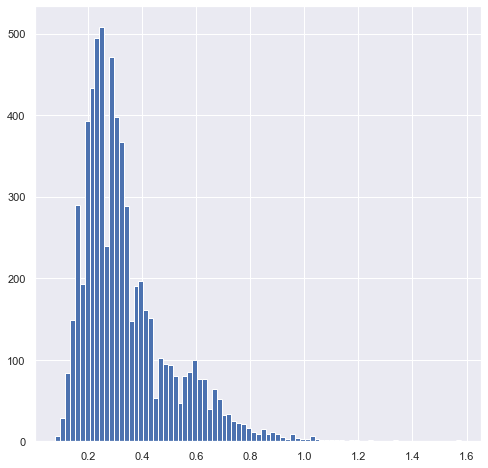

In [52]:
wine['volatile acidity'].hist(bins='auto');

Suppose we add more bins:

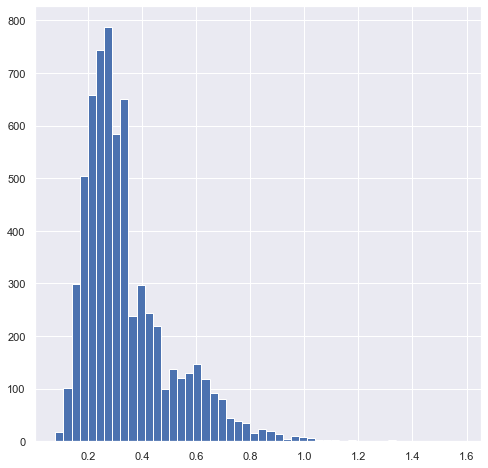

In [51]:
wine['volatile acidity'].hist(bins=50);

Now the distribution looks quite different. There seems to be a small second peak around 0.6. And we can reproduce this if we check out `seaborn`'s kernel density plot.

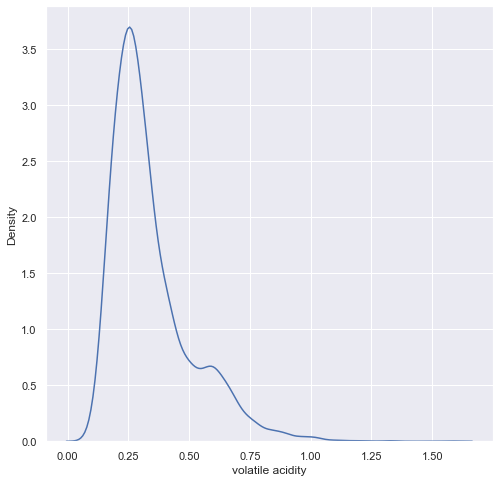

In [53]:
sns.kdeplot(wine['volatile acidity']);

So suppose we build a new feature that records whether a wine's volatile acidity is above 0.5.

In [54]:
wine['volatile acidity'] > 0.5

0        True
1        True
2        True
3       False
4        True
        ...  
6492    False
6493    False
6494    False
6495    False
6496    False
Name: volatile acidity, Length: 6497, dtype: bool

In [55]:
wine['high_va'] = wine['volatile acidity'] > 0.5

In [56]:
wine.head()

fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0            7.4              0.70         0.00             1.9      0.076   
1            7.8              0.88         0.00             2.6      0.098   
2            7.8              0.76         0.04             2.3      0.092   
3           11.2              0.28         0.56             1.9      0.075   
4            7.4              0.70         0.00             1.9      0.076   

   free sulfur dioxide  total sulfur dioxide  density    pH  sulphates  \
0                 11.0                  34.0   0.9978  3.51       0.56   
1                 25.0                  67.0   0.9968  3.20       0.68   
2                 15.0                  54.0   0.9970  3.26       0.65   
3                 17.0                  60.0   0.9980  3.16       0.58   
4                 11.0                  34.0   0.9978  3.51       0.56   

   alcohol  quality  red_wine  high_va  
0      9.4        5         1     True  
1      9.8        5         1     True  
2      9.8        5         1     True  
3      9.8        6         1    False  
4      9.4        5         1     True

In [57]:
# Now we can build a new model with this feature.

wine_preds2 = wine[['alcohol', 'density', 'high_va']]

In [61]:
sm.OLS(endog=wine_target, exog=sm.add_constant(wine_preds2)).fit().summary()

ValueError: Pandas data cast to numpy dtype of object. Check input data with np.asarray(data).

In [59]:
lr2 = LinearRegression().fit(wine_preds2, wine_target)

In [60]:
lr2.score(wine_preds2, wine_target)

0.2301961367656522

Not bad! We don't seem to have stumbled onto a huge connection here, but this correlation value suggests that this new feature may be helpful in a final model.

### $\bf{SO_2}$

Next we'll take a look at distribution of the sulfur dioxide feature:

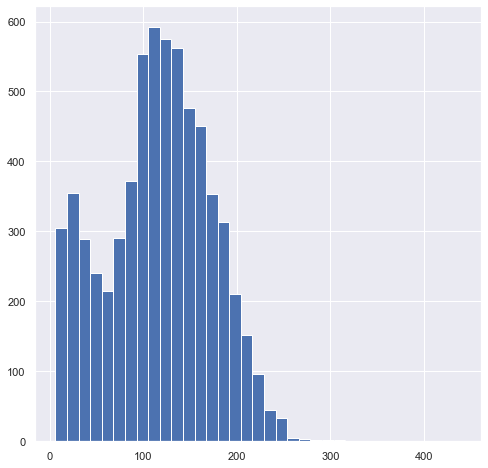

In [62]:
wine['total sulfur dioxide'].hist(bins=35);

Let's try separating our wines into those with sulfur dioxide higher than 80 and those with less:

In [63]:
wine['high_so2'] = wine['total sulfur dioxide'] > 80

In [64]:
wine.corr()['quality']['high_so2']

0.08074521567591902

Not great. Perhaps this is a modeling dead end.

## Products of Features

Another engineering strategy we might try is **multiplying features together**.

Let's try these two features: `residual sugar` and `total sulfur dioxide`. Note that without domain knowledge or exploration, this is really a guess that this combination will predict `quality` well.

In [65]:
wine['rs*tsd'] = wine['residual sugar'] * wine['total sulfur dioxide']

In [66]:
wine.head()

fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0            7.4              0.70         0.00             1.9      0.076   
1            7.8              0.88         0.00             2.6      0.098   
2            7.8              0.76         0.04             2.3      0.092   
3           11.2              0.28         0.56             1.9      0.075   
4            7.4              0.70         0.00             1.9      0.076   

   free sulfur dioxide  total sulfur dioxide  density    pH  sulphates  \
0                 11.0                  34.0   0.9978  3.51       0.56   
1                 25.0                  67.0   0.9968  3.20       0.68   
2                 15.0                  54.0   0.9970  3.26       0.65   
3                 17.0                  60.0   0.9980  3.16       0.58   
4                 11.0                  34.0   0.9978  3.51       0.56   

   alcohol  quality  red_wine  high_va  high_so2  rs*tsd  
0      9.4        5         1     True     False    64.6  
1      9.8        5         1     True     False   174.2  
2      9.8        5         1     True     False   124.2  
3      9.8        6         1    False     False   114.0  
4      9.4        5         1     True     False    64.6

In [67]:
wine.corr()['quality']['rs*tsd']

-0.06622845877790091

In [68]:
wine.corr()['quality']['residual sugar']

-0.03698048458576987

In [69]:
wine.corr()['quality']['total sulfur dioxide']

-0.04138545385560974

We can see these two features together have a higher correlation than each by itself!

## Polynomial Features

Instead of just multiplying features at random, we might consider trying **every possible product of features**. That's what PolynomialFeatures does:

In [70]:
pf = PolynomialFeatures(degree=3)

X = wine.drop('quality', axis=1)
y = wine['quality']

# Fitting the PolynomialFeatures object
pf.fit(X)

PolynomialFeatures(degree=3)

In [73]:
X

fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0               7.4              0.70         0.00             1.9      0.076   
1               7.8              0.88         0.00             2.6      0.098   
2               7.8              0.76         0.04             2.3      0.092   
3              11.2              0.28         0.56             1.9      0.075   
4               7.4              0.70         0.00             1.9      0.076   
...             ...               ...          ...             ...        ...   
6492            6.2              0.21         0.29             1.6      0.039   
6493            6.6              0.32         0.36             8.0      0.047   
6494            6.5              0.24         0.19             1.2      0.041   
6495            5.5              0.29         0.30             1.1      0.022   
6496            6.0              0.21         0.38             0.8      0.020   

      free sulfur dioxide  total sulfur dioxide  density    pH  sulphates  \
0                    11.0                  34.0  0.99780  3.51       0.56   
1                    25.0                  67.0  0.99680  3.20       0.68   
2                    15.0                  54.0  0.99700  3.26       0.65   
3                    17.0                  60.0  0.99800  3.16       0.58   
4                    11.0                  34.0  0.99780  3.51       0.56   
...                   ...                   ...      ...   ...        ...   
6492                 24.0                  92.0  0.99114  3.27       0.50   
6493                 57.0                 168.0  0.99490  3.15       0.46   
6494                 30.0                 111.0  0.99254  2.99       0.46   
6495                 20.0                 110.0  0.98869  3.34       0.38   
6496                 22.0                  98.0  0.98941  3.26       0.32   

      alcohol  red_wine  high_va  high_so2  rs*tsd  
0         9.4         1     True     False    64.6  
1         9.8         1     True     False   174.2  
2         9.8         1     True     False   124.2  
3         9.8         1    False     False   114.0  
4         9.4         1     True     False    64.6  
...       ...       ...      ...       ...     ...  
6492     11.2         0    False      True   147.2  
6493      9.6         0    False      True  1344.0  
6494      9.4         0    False      True   133.2  
6495     12.8         0    False      True   121.0  
6496     11.8         0    False      True    78.4  

[6497 rows x 15 columns]

In [71]:
pdf = pd.DataFrame(pf.transform(X), columns=pf.get_feature_names())
pdf

1    x0    x1    x2   x3     x4    x5     x6       x7    x8  ...  \
0     1.0   7.4  0.70  0.00  1.9  0.076  11.0   34.0  0.99780  3.51  ...   
1     1.0   7.8  0.88  0.00  2.6  0.098  25.0   67.0  0.99680  3.20  ...   
2     1.0   7.8  0.76  0.04  2.3  0.092  15.0   54.0  0.99700  3.26  ...   
3     1.0  11.2  0.28  0.56  1.9  0.075  17.0   60.0  0.99800  3.16  ...   
4     1.0   7.4  0.70  0.00  1.9  0.076  11.0   34.0  0.99780  3.51  ...   
...   ...   ...   ...   ...  ...    ...   ...    ...      ...   ...  ...   
6492  1.0   6.2  0.21  0.29  1.6  0.039  24.0   92.0  0.99114  3.27  ...   
6493  1.0   6.6  0.32  0.36  8.0  0.047  57.0  168.0  0.99490  3.15  ...   
6494  1.0   6.5  0.24  0.19  1.2  0.041  30.0  111.0  0.99254  2.99  ...   
6495  1.0   5.5  0.29  0.30  1.1  0.022  20.0  110.0  0.98869  3.34  ...   
6496  1.0   6.0  0.21  0.38  0.8  0.020  22.0   98.0  0.98941  3.26  ...   

      x12^3  x12^2 x13  x12^2 x14  x12 x13^2  x12 x13 x14  x12 x14^2  x13^3  \
0       1.0        0.0       64.6        0.0          0.0    4173.16    0.0   
1       1.0        0.0      174.2        0.0          0.0   30345.64    0.0   
2       1.0        0.0      124.2        0.0          0.0   15425.64    0.0   
3       0.0        0.0        0.0        0.0          0.0       0.00    0.0   
4       1.0        0.0       64.6        0.0          0.0    4173.16    0.0   
...     ...        ...        ...        ...          ...        ...    ...   
6492    0.0        0.0        0.0        0.0          0.0       0.00    1.0   
6493    0.0        0.0        0.0        0.0          0.0       0.00    1.0   
6494    0.0        0.0        0.0        0.0          0.0       0.00    1.0   
6495    0.0        0.0        0.0        0.0          0.0       0.00    1.0   
6496    0.0        0.0        0.0        0.0          0.0       0.00    1.0   

      x13^2 x14   x13 x14^2         x14^3  
0           0.0        0.00  2.695861e+05  
1           0.0        0.00  5.286210e+06  
2           0.0        0.00  1.915864e+06  
3           0.0        0.00  1.481544e+06  
4           0.0        0.00  2.695861e+05  
...         ...         ...           ...  
6492      147.2    21667.84  3.189506e+06  
6493     1344.0  1806336.00  2.427716e+09  
6494      133.2    17742.24  2.363266e+06  
6495      121.0    14641.00  1.771561e+06  
6496       78.4     6146.56  4.818903e+05  

[6497 rows x 816 columns]

<AxesSubplot:>

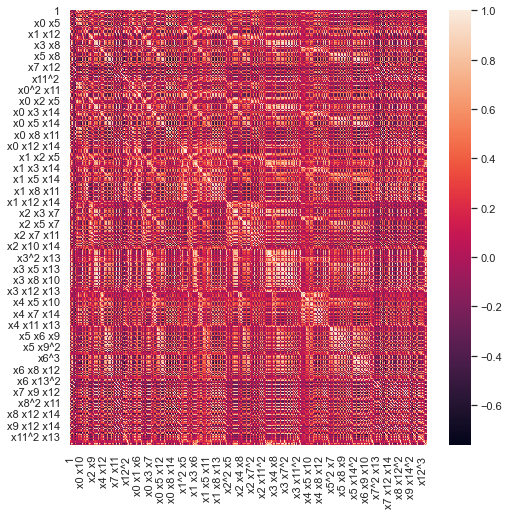

In [77]:
sns.heatmap(pdf.corr())

In [82]:
X['fa_2'] = X['fixed acidity']**2
X

fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0               7.4              0.70         0.00             1.9      0.076   
1               7.8              0.88         0.00             2.6      0.098   
2               7.8              0.76         0.04             2.3      0.092   
3              11.2              0.28         0.56             1.9      0.075   
4               7.4              0.70         0.00             1.9      0.076   
...             ...               ...          ...             ...        ...   
6492            6.2              0.21         0.29             1.6      0.039   
6493            6.6              0.32         0.36             8.0      0.047   
6494            6.5              0.24         0.19             1.2      0.041   
6495            5.5              0.29         0.30             1.1      0.022   
6496            6.0              0.21         0.38             0.8      0.020   

      free sulfur dioxide  total sulfur dioxide  density    pH  sulphates  \
0                    11.0                  34.0  0.99780  3.51       0.56   
1                    25.0                  67.0  0.99680  3.20       0.68   
2                    15.0                  54.0  0.99700  3.26       0.65   
3                    17.0                  60.0  0.99800  3.16       0.58   
4                    11.0                  34.0  0.99780  3.51       0.56   
...                   ...                   ...      ...   ...        ...   
6492                 24.0                  92.0  0.99114  3.27       0.50   
6493                 57.0                 168.0  0.99490  3.15       0.46   
6494                 30.0                 111.0  0.99254  2.99       0.46   
6495                 20.0                 110.0  0.98869  3.34       0.38   
6496                 22.0                  98.0  0.98941  3.26       0.32   

      alcohol  red_wine  high_va  high_so2  rs*tsd    fa_2  
0         9.4         1     True     False    64.6   54.76  
1         9.8         1     True     False   174.2   60.84  
2         9.8         1     True     False   124.2   60.84  
3         9.8         1    False     False   114.0  125.44  
4         9.4         1     True     False    64.6   54.76  
...       ...       ...      ...       ...     ...     ...  
6492     11.2         0    False      True   147.2   38.44  
6493      9.6         0    False      True  1344.0   43.56  
6494      9.4         0    False      True   133.2   42.25  
6495     12.8         0    False      True   121.0   30.25  
6496     11.8         0    False      True    78.4   36.00  

[6497 rows x 16 columns]

In [74]:
pdf.shape

(6497, 816)

In [75]:
lr = LinearRegression()

lr.fit(pdf, y)

LinearRegression()

In [76]:
lr.score(pdf, y)

0.5078100671100381

So: Is this a good idea? What are the potential dangers here?

For inferential modelling - need to be very worried about multicollinearity

For predictive modelling - much less worried

## Exercise

Consider the following dataset:

In [83]:
sales = pd.read_csv('data/Advertising.csv', index_col=0)

sales.head()

TV  radio  newspaper  sales
1  230.1   37.8       69.2   22.1
2   44.5   39.3       45.1   10.4
3   17.2   45.9       69.3    9.3
4  151.5   41.3       58.5   18.5
5  180.8   10.8       58.4   12.9

We'd like to try to understand sales as a function of spending on various media (TV, radio, newspaper).

In [84]:
sales.corr()['sales']

TV           0.782224
radio        0.576223
newspaper    0.228299
sales        1.000000
Name: sales, dtype: float64

**Try to find the best multiplicative combination of features.**

You may use `PolynomialFeatures` or just multiply by hand.

In practice, it's not easy to tell when such products of features will be so fruitful. Moreover, there is room for concern about violating regression's demand for feature independence. At the very least, we would probably not want to include a product *and the individual features themselves* in a final model, not if our goal is to understand what's really responsible for fluctuations in our target variable.